In [1]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import seaborn as sns
from copy import deepcopy
from os.path import join
import site
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
from scipy.stats import mannwhitneyu, normaltest
from scipy.special import softmax
site.addsitedir('../include')

from visualize import plot_action_list, get_labels
from utils import load_action_map, f_score, edit_score, collaps_confusion_matrix


## Per video result analysis
- calculate metrics per video
- scatter plot video length / performance

In [14]:
# Experiment 2: Case by case analysis
def prepare_folder_structure(results_dir):
    if os.path.exists(join(results_dir, 'splits')):
        shutil.rmtree(join(results_dir, 'splits'))
    os.makedirs(join(results_dir, 'splits'))
    for k in range(0, 7, 1):
        shutil.copy_tree(join(results_dir, f'split_{k}'), join(results_dir, 'splits'))
        

def remove_columns(probabilites, actions_dict, gt_content):
    idx_to_remove = []
    for action in actions_dict.keys():
        if action not in set(gt_content):
            idx_to_remove.append(actions_dict[action])
    probabilites = np.delete(probabilites, idx_to_remove, axis=0)
    return probabilites

def get_scores_for_vid(video_id, results_path, ground_truth_dir, overlap=0.25):
    encoder = OneHotEncoder(sparse_output=False)
    ground_truth = open(join(ground_truth_dir, video_id + '.txt'), 'r').read().split('\n')
    prediction = open(join(results_path, video_id), 'r').read().split('\n')[1].split()
    probs = np.load(join(results_path, video_id + ".npy"))
    action_dict = load_action_map(join(ground_truth_dir, '../mapping.txt'))
    
    ground_truth = ground_truth[0:len(prediction)] if len(prediction) < len(ground_truth) else ground_truth
    prediction = prediction[0:len(ground_truth)] if len(prediction) >= len(ground_truth) else prediction

    edit = edit_score(prediction, ground_truth, bg_class=[''])
    accuracy = sum([1 for p, g in zip(prediction, ground_truth) if p == g]) / len(prediction) * 100
    tp, fp, fn = f_score(prediction, ground_truth, overlap, bg_class=[''])
    f1 = 2 * tp / (2*tp+fp+fn) * 100
    
    tp, tn, fp, fn = collaps_confusion_matrix(ground_truth, prediction)
    sensitivity = tp / (tp + fn) * 100.0
    specificity = tn / (tn + fp) * 100.0
    
    
    probs = softmax(probs, axis=0)
    probs = remove_columns(probs, action_dict, ground_truth)
    actions2num = np.vectorize(lambda d: action_dict[d])
    ground_truth = actions2num(ground_truth)
    y_true = encoder.fit_transform(ground_truth.reshape(-1, 1)).T
    roc_auc = roc_auc_score(y_true.ravel(), probs.ravel(), average='macro')
    pr_auc = average_precision_score(y_true.ravel(), probs.ravel())
    
    return f1, edit, accuracy, sensitivity, specificity, roc_auc, pr_auc


def accumlate_resutlts(gt_dir, results_path, fps=30.0):
    scores = {'video_id': [], 'accuracy': [], 'edit': [], 'f1': [], 'sensitivity': [], 'specificity': [], 'roc': [], 'pr': [], 'length': []}

    for i in range(0, len(os.listdir(gt_dir))):
        ground_truth_path = os.listdir(gt_dir)[i]
        ground_truth_id = os.path.splitext(ground_truth_path)[0]
        if not os.path.exists(join(results_path, ground_truth_id)):
            continue
        
        f1, edit, accuracy, sen, spec, roc, pr = get_scores_for_vid(ground_truth_id, results_path, gt_dir)
        vid_length = len(open(join(gt_dir, ground_truth_path), 'r').readlines()) / fps / 60.0

        # print(f'{ground_truth_id}> edit score: {edit:.2f}, f1@0.25: {f1:.2f}, accuracy: {accuracy:.2f}, video length: {vid_length:.2f}')
        scores['edit'].append(edit)
        scores['f1'].append(f1)
        scores['accuracy'].append(accuracy)
        scores['sensitivity'].append(sen)
        scores['specificity'].append(spec)
        scores['roc'].append(roc)
        scores['pr'].append(pr)
        scores['length'].append(vid_length)
        scores['video_id'].append(ground_truth_id)
    avg_scores = {'avg_acc': np.mean(scores["accuracy"]), 'avg_edit': np.mean(scores["edit"]), 'avg_f1': np.mean(scores["f1"])}
    print(f'Average edit score: {avg_scores["avg_edit"]:.2f}, f1 score: {avg_scores["avg_f1"]:.2f}, accuracy: {avg_scores["avg_acc"]:.2f}, sensitivity: {np.mean(scores["sensitivity"]):.2f}, specificity: {np.mean(scores["specificity"]):.2f}')
    return scores, avg_scores


#results_path = r"C:\Users\smuel\Pictures\Results WESP\sics73_mse0.3_splits\results" gt_dir = r"C:\Users\smuel\Data\2024_SICS_Phase\groundTruth2"
results_path = "/home/simon/Code/MS-TCN2/results/cataract101_rgb/splits/"
gt_path = "/home/simon/Code/MS-TCN2/data/cataract101_rgb/groundTruth/"
scores, avg_scores = accumlate_resutlts(gt_path, results_path)

results_path = "/home/simon/Code/MS-TCN2/results/sics105_c13_nobg2/splits/"
gt_path = "/home/simon/Code/MS-TCN2/data/sics105_c13_nobg2/groundTruth/"
# prepare_folder_structure("/home/simon/Code/MS-TCN2/results/sics105_c13_nobg2")
scores_sics, avg_scores_sics = accumlate_resutlts(gt_path, results_path, fps=15)

#results_path = r"C:\Users\smuel\Pictures\Results WESP\cataract101_rgb\results"
#gt_dir = join(base_dir, 'groundTruth')


Average edit score: 84.23, f1 score: 86.82, accuracy: 90.88, sensitivity: 90.88, specificity: 98.46
Average edit score: 78.81, f1 score: 80.55, accuracy: 80.56, sensitivity: 80.56, specificity: 95.72


[Text(0.5, 0, 'Accuracy (%)'), Text(0, 0.5, 'Frequency (%)')]

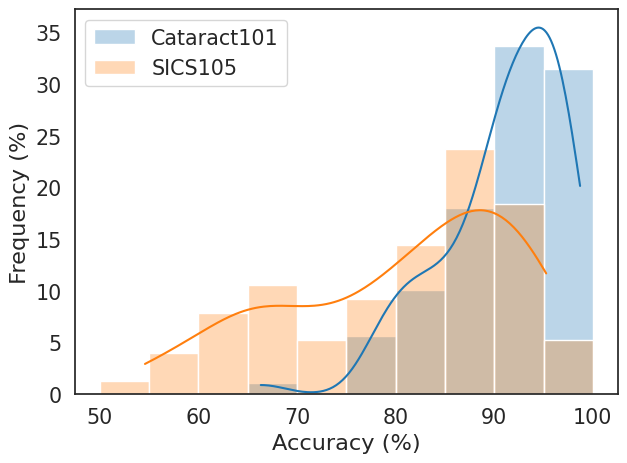

In [16]:
figure = plt.figure(figsize=(7, 5))
params = {'alpha': 0.3, 'legend': True, 'kde': True, 'stat': "percent", 'discrete': False, 'element': "bars", 'bins': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]} #"binwidth": 4
plot = sns.histplot(scores['accuracy'], label='Cataract101', **params)
plot = sns.histplot(scores_sics['accuracy'], label='SICS105', **params)
plot.legend(loc='upper left')
plot.set(xlabel='Accuracy (%)', ylabel='Frequency (%)')

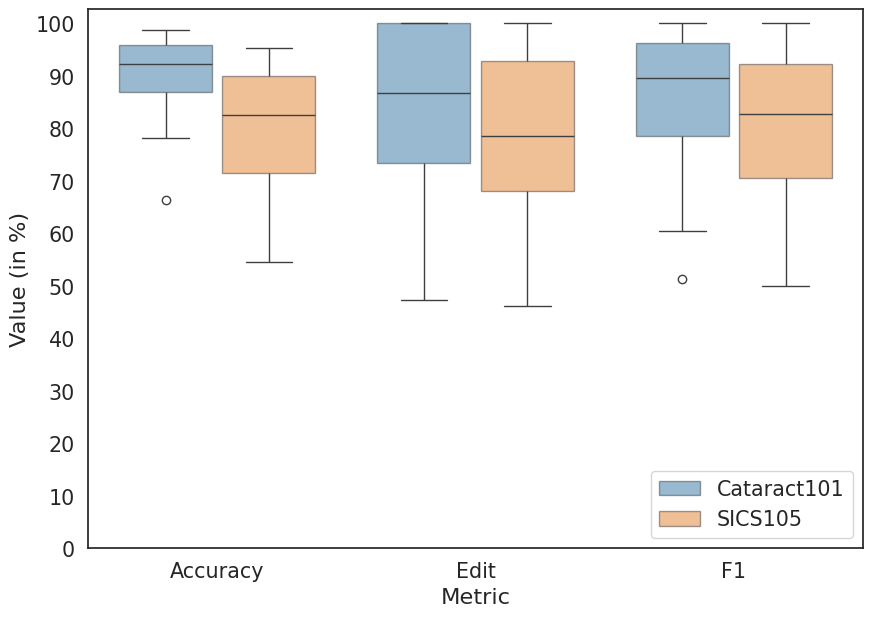

In [15]:
figure = plt.figure(figsize=(10, 7))
data = {'Cataract101_acc': scores['accuracy'], 'Cataract101_f1': scores['f1'], 
        'SICS105_acc': scores_sics['accuracy'], 'SICS105_f1': scores_sics['f1']}
try:
        del scores['length']
        del scores_sics['length']
except: pass

scores['group'] = ['Cataract101'] * len(scores['accuracy'])
scores_sics['group'] = ['SICS105'] * len(scores_sics['accuracy'])
df = pd.DataFrame(scores)
df2 = pd.DataFrame(scores_sics)

new = pd.concat([df, df2], axis=0)
new = pd.melt(new, id_vars=['group'], value_vars=['accuracy', 'edit', 'f1'])
new["variable"] = new["variable"].replace({"edit": "Edit", "f1": "F1", "accuracy": "Accuracy"})

#sns.set(font_scale=1.2)
# sns.set_style("white")
sns.set_context("notebook", font_scale=1.35)
#plot = sns.violinplot(data=new, x="variable", y="value", palette=None, inner="box", alpha=0.5, hue='group', cut=0.5)
plot = sns.boxplot(data=new, x="variable", y="value", palette=None, hue='group', gap=0.1, boxprops=dict(alpha=0.5))
#plot = sns.swarmplot(data=new, x="variable", y="value", palette=None, hue='group', alpha=0.5)
plot.set_yticks(range(0, 101, 10))
plot.set_xlabel('Metric')
plot.set_ylabel('Value (in %)')
#sns.violinplot(df2, palette=None, inner="box", alpha=0.5)
plot.legend(loc='lower right')
#plot.grid(axis='y')



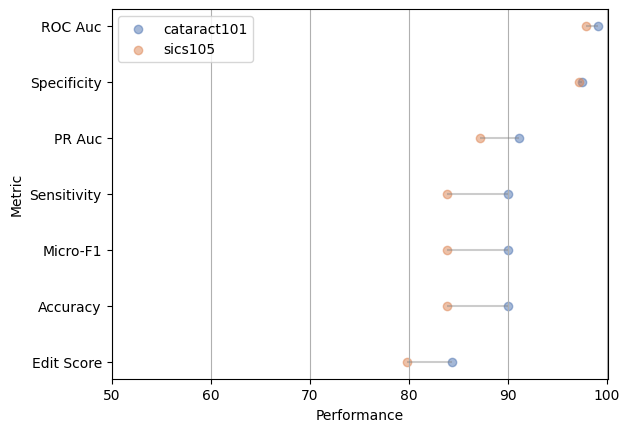

In [4]:
metrics = ["Accuracy", "Edit Score", "Micro-F1", "ROC Auc", "PR Auc", "Sensitivity", "Specificity"]
values1 = [89.97, 84.33, 89.97, 99.10, 91.14, 89.97, 97.49]
values2 = [83.86, 79.79, 83.86, 97.91, 87.18, 83.86, 97.23]

df = pd.DataFrame({'metric': metrics, 'cataract101': values1, 'sics105': values2})


ordered_df = df.sort_values(by='cataract101')
my_range=range(1,len(df.index)+1)
 
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=ordered_df['cataract101'], xmax=ordered_df['sics105'], color='grey', alpha=0.4)
plt.scatter(ordered_df['cataract101'], my_range, color='#4c72b0', alpha=0.5, label='cataract101')
plt.scatter(ordered_df['sics105'], my_range, color='#dd8452', alpha=0.5, label='sics105')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['metric'])
# plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xticks(range(50, 101, 10))
plt.xlabel('Performance')
plt.ylabel('Metric')
plt.grid(axis='x')

# Show the graph
plt.show()

In [10]:
from scipy.stats import mannwhitneyu, normaltest, false_discovery_control
from statsmodels.stats.multitest import multipletests

results_path = "/home/simon/Code/MS-TCN2/results/cataract101_rgb/split_9/"
gt_path = "/home/simon/Code/MS-TCN2/data/cataract101_rgb/groundTruth/"
scores_phaco, avg_scores = accumlate_resutlts(gt_path, results_path)

results_path = "/home/simon/Code/MS-TCN2/results/sics105_c13_nobg2/split_9/"
gt_path = "/home/simon/Code/MS-TCN2/data/sics105_c13_nobg2/groundTruth/"
scores_sics, avg_scores_sics = accumlate_resutlts(gt_path, results_path, fps=15)

metrics = ["f1", "accuracy", "edit", "sensitivity", "specificity", "roc", "pr"]
metric = "f1"
print("Preparing statisical test between datasets, dataset sizes (phaco, sics): ", len(scores_phaco['accuracy']), len(scores_sics['accuracy']))

#print(f"Phaco dataset propability for nomral distribution ({metric}): {normaltest(scores_phaco[metric]).pvalue:0.4f}")
#print(f"SICS dataset propability for nomral distribution ({metric}): {normaltest(scores_sics[metric]).pvalue:0.4f}")
print()

print(f"Mann-Whitney U test for the null-hypothesis that the underlying distribution of values from both datasets is the same: ")
ps = {}
for metric in metrics: 
    u_stat, p_value = mannwhitneyu(scores_phaco[metric], scores_sics[metric], method='auto')
    ps[metric] = p_value


corrected_ps = false_discovery_control(list(ps.values()), method='by')
corrected_ps = multipletests(list(ps.values()), method='bonferroni', alpha=0.05)[1]
for i, k in enumerate(ps.keys()):
    print(f"{k.capitalize()}: p-value = {ps[k]:0.4f}, corr. p-value = {corrected_ps[i]:0.4f}", end="")
    if corrected_ps[i] < 0.01:
        print("**")
    elif corrected_ps[i] < 0.05:
        print("*")
    else: 
        print()



Average edit score: 83.88, f1 score: 87.20, accuracy: 91.75, sensitivity: 91.75, specificity: 98.69
Average edit score: 84.50, f1 score: 86.85, accuracy: 85.72, sensitivity: 85.72, specificity: 96.81
Preparing statisical test between datasets, dataset sizes (phaco, sics):  14 17

Mann-Whitney U test for the null-hypothesis that the underlying distribution of values from both datasets is the same: 
F1: p-value = 1.0000, corr. p-value = 1.0000
Accuracy: p-value = 0.0842, corr. p-value = 0.5896
Edit: p-value = 0.7774, corr. p-value = 1.0000
Sensitivity: p-value = 0.0842, corr. p-value = 0.5896
Specificity: p-value = 0.0305, corr. p-value = 0.2136
Roc: p-value = 0.0916, corr. p-value = 0.6412
Pr: p-value = 0.0649, corr. p-value = 0.4545


/tmp/ipykernel_3593600/232248697.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.histplot(scores_phaco['accuracy'], label='Cataract101', **params)
/tmp/ipykernel_3593600/232248697.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.histplot(scores_sics['accuracy'], label='SICS105', **params)


[Text(0.5, 0, 'Accuracy (%)'), Text(0, 0.5, 'Frequency (%)')]

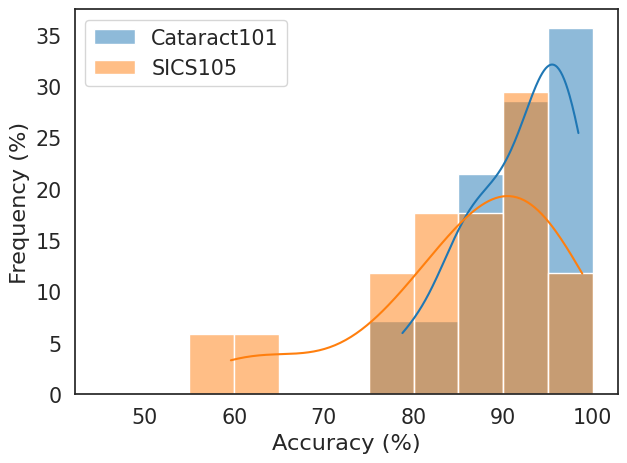

In [13]:
figure = plt.figure(figsize=(7, 5))
params = {'alpha': 0.5, 'legend': True, 'palette': "tab10", 'kde': True, 'stat': "percent", 'discrete': False, 'element': "bars", 'bins': np.arange(45, 101, 5)} #"binwidth": 4
plot = sns.histplot(scores_phaco['accuracy'], label='Cataract101', **params)
plot = sns.histplot(scores_sics['accuracy'], label='SICS105', **params)
plot.legend(loc='upper left')
plot.set(xlabel='Accuracy (%)', ylabel='Frequency (%)')

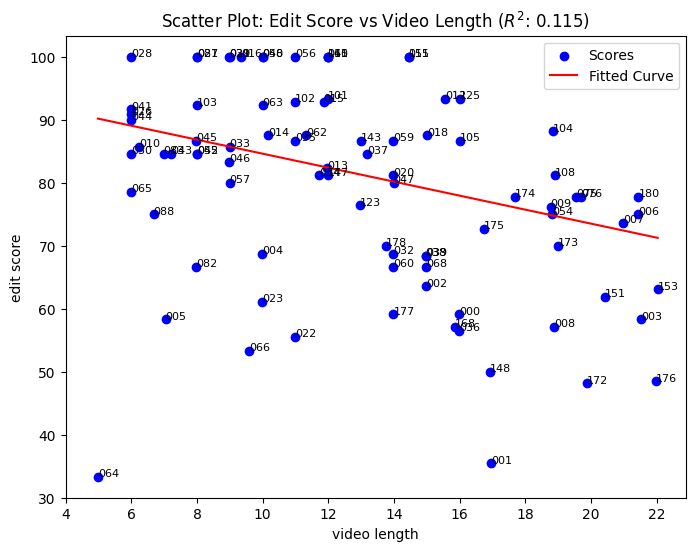

In [22]:
def model_func(x, a, b, c):
    return a * np.exp(-b * x) + c # Define the exponential model function

x_values, y_values = np.array(scores_sics['length']), np.array(scores_sics['edit'])
opt_params, param_cov = optimize.curve_fit(model_func, x_values, y_values, loss='soft_l1', method='trf', max_nfev=20000) # Fit the nonlinear model
xx = np.linspace(min(x_values), max(x_values), 1000) # Generate fitted curve
yy = model_func(xx, *opt_params)

predicted_values = model_func(x_values, *opt_params) # Calculate residuals
residuals = y_values - predicted_values
TSS = np.sum((y_values - np.mean(y_values))**2) # Calculate TSS and RSS
RSS = np.sum(residuals**2)
R_squared = 1 - RSS / TSS # Calculate R-squared

fig = plt.figure(figsize=(8, 6)) # Plot the scatter data and the fitted curve
plt.scatter(x_values, y_values, label='Scores', color='b')
for i, identifier in enumerate(scores['video_id']):
    plt.annotate(identifier[-3:], (x_values[i], y_values[i]), fontsize=8)
plt.plot(xx, yy, label='Fitted Curve', color='red')
plt.xlabel('video length')
plt.xticks(np.arange(int(min(x_values)), int(max(x_values)) + 2, 2.0))
plt.ylabel('edit score')
#plt.grid()
plt.legend()
plt.title(f'Scatter Plot: Edit Score vs Video Length ($R^2$: {R_squared:.3f})')
plt.show()

In [20]:
from scipy import stats
scores = scores_sics
# Calculate the Spearman correlation coefficient
corr, p_value = stats.spearmanr(scores['length'], scores['edit'])
print(f"Spearman correlation coefficient: {corr:.4f} (p={p_value:.8f})")

corr, p_value = stats.pearsonr(scores['length'], scores['edit'])
print(f"Pearson correlation coefficient: {corr:.4f} (p={p_value:.8f})")

Spearman correlation coefficient: -0.3960 (p=0.00013399)
Pearson correlation coefficient: -0.3784 (p=0.00027806)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


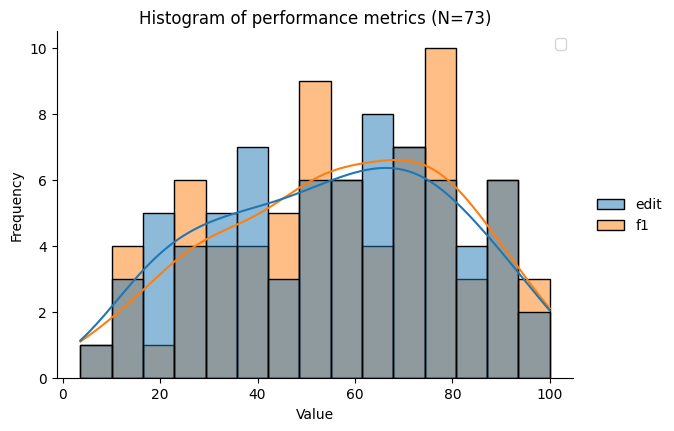

In [7]:
bins = 15
data = deepcopy(scores)
del data['length']
del data['accuracy']
del data['video_id']
# Plot overlapping histograms
# plt.hist(scores['f1'], bins=bins, alpha=0.5, label='F1@0.25', color='orange', ec=None)
sns.displot(data, kde=True, bins=bins, height=4, aspect=1.5)

plt.xlabel('Value') # Add labels and legend
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Histogram of performance metrics (N={len(scores["f1"])})')
plt.show()

## Bootstrap test metrics for CIs

In [8]:
def prepare_results(ground_truth_dir, results_dir, action_dict, sample_rate=1):
    results_files = os.listdir(results_dir)
    probability_files = [file for file in results_files if 'npy' in file]

    actions2num = np.vectorize(lambda d: action_dict[d])
    results = {"labels": [], "predictions": [], "probs": []}

    for probs_files in tqdm(probability_files):
        probs = np.load(join(results_dir, probs_files))[:, 0::sample_rate]
        prediction = open(join(results_dir, probs_files.replace('npy', '')), 'r').read().split('\n')[1].split()
        ground_truth = open(join(ground_truth_dir, probs_files.replace('npy', 'txt')), 'r').read().split('\n')
        ground_truth = ground_truth[0::sample_rate]
        ground_truth = ground_truth[:probs.shape[1]]
        prediction = prediction[0::sample_rate]
        prediction = prediction[:probs.shape[1]]
        assert probs.shape[1] == len(ground_truth)

        ground_truth = actions2num(ground_truth)
        prediction = actions2num(prediction)

        results["labels"].append(ground_truth)
        results["predictions"].append(prediction)
        results["probs"].append(probs)
    return results

results_dir = r"C:\Users\smuel\Pictures\Results WESP\sics88_c13_nobg"
gt_dir = r"C:\Users\smuel\Data\2024_SICS_Phase\groundTruth88_c13_nobg"

action_dict = load_action_map(join(results_dir,'mapping.txt'))
rev_actions = {v: k for k, v in action_dict.items()}

results = prepare_results(gt_dir, results_dir, action_dict, sample_rate=10)
print(len(results["labels"]))

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 117.49it/s]

13


In [10]:
def bootstrap_test_metric(results, metric, alpha=0.5, num_samples=300, seed=0):
    rng = np.random.RandomState(seed=seed)
    idx = np.arange(len(results['labels']))
    accumulation_metric = []
    encoder = OneHotEncoder(sparse_output=False)

    for _ in range(num_samples):
        pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
        boot_label = [label for j, label in enumerate(results['labels']) if j in pred_idx]
        boot_pred = [pred for j, pred in enumerate(results['predictions']) if j in pred_idx]
        boot_prob = [probs for j, probs in enumerate(results['probs']) if j in pred_idx]
        
        if metric == metrics.roc_auc_score or metric == metrics.average_precision_score:
            y_true = encoder.fit_transform(np.concatenate(boot_label).reshape(-1, 1)).T
            test_mean = metric(y_true.ravel(), np.concatenate(boot_prob, axis=1).ravel(), average='micro')
        else:
            test_mean = metric(np.concatenate(boot_label), np.concatenate(boot_pred))
        
        accumulation_metric.append(test_mean)
    
    bootstrap_mean = np.mean(accumulation_metric)
    ci_lower = np.percentile(accumulation_metric, alpha/2.0)
    ci_upper = np.percentile(accumulation_metric, 100-alpha/2.0)
    return bootstrap_mean, (ci_lower, ci_upper)


print(bootstrap_test_metric(results, metrics.accuracy_score, alpha=5.0, seed=0))
print(bootstrap_test_metric(results, lambda a, b: metrics.f1_score(a, b, average='macro'), alpha=5.0,seed=0))
print(bootstrap_test_metric(results, metrics.roc_auc_score, alpha=5.0, seed=0))
print(bootstrap_test_metric(results, metrics.average_precision_score, alpha=5.0, seed=0))

(0.8074646636935718, (0.7719501877881831, 0.848754951391989))
(0.7712986387538425, (0.730016153159002, 0.8233855330849494))
(0.9734068560256018, (0.9624669020792617, 0.9842611425131328))
(0.8257093426542069, (0.7814895535866706, 0.8741784792427862))
